In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
import functions
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = True # Specify if noisy or not
Noise_level = 0.01 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
# objective = functions.sincos(Noise, Noise_level)
# objective = functions.Shubert(Noise, Noise_level)
objective = functions.Ackley_2(Noise, Noise_level)

bounds = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(bounds) 

f = objective.func
print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-2.  2.]
 [-2.  2.]]
[[5.42007414]]
dim:  2


In [4]:
# set seed
seed = 0
# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

In [5]:
def draw(n_random_draws=3):
    """ samples some points"""
    # np.random.seed(seed) 
    # should draw randomly
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_random_draws, dim))
    return X, f(X)

def get_kernel(sample_size=4):
    np.random.seed(seed)
    X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(sample_size, dim)))
    gp.set_data(X, f(X))
    gp.optimize()
    gp.fit()
    return gp.get_hyper()

In [6]:
gp = GP_grad(bounds, Noise, Noise_level)
# creating meshgrid to plot over entire range
x1 = np.linspace(bounds[0, 0], bounds[0, 1], 100)
x2 = np.linspace(bounds[1, 0], bounds[1, 1], 100)

X1, X2 = np.meshgrid(x1, x2)
mesh = np.vstack((X1.flatten(), X2.flatten())).T

In [7]:
mesh, f(mesh)

(array([[-2.        , -2.        ],
        [-1.95959596, -2.        ],
        [-1.91919192, -2.        ],
        ...,
        [ 1.91919192,  2.        ],
        [ 1.95959596,  2.        ],
        [ 2.        ,  2.        ]]),
 array([[6.61356791],
        [6.59345098],
        [6.65658742],
        ...,
        [6.64462225],
        [6.59150965],
        [6.59150989]]))

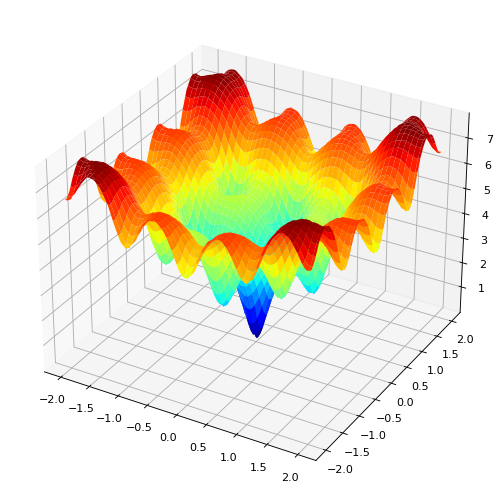

In [8]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(mesh).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()

In [9]:
# from scipy.optimize import minimize
# opts = {"maxiter": 200, "maxfun": 200, "disp": False}
# # bounds = np.asarray([[2, 10], [2, 10]])  # bounds on x

# Space = np.array([])

# for u in mesh:
#     Space = np.append(Space, f(u))
        
# x0 = mesh[np.argmax(Space)]
# x0 
        
# Res = minimize(lambda x: f(x), 
#                         x0=x0,
#                         bounds=bounds, 
#                         method="L-BFGS-B", 
#                         options=opts) # L-BFGS-B


# # print("minima: ", Res.x)
# argmin, minima = np.array(Res.x), f(Res.x)
# argmin, minima

In [10]:
get_kernel() # optimize hyper and fit alpha
print(gp.get_hyper())

# posterior mean and cov
mu, covar = gp.posterior(mesh)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)

Kt = gp.cov_RBF(mesh, mesh, gp.get_hyper())
K_11 = gp.K11(mesh)
K_01 = gp.K01(mesh)

{'var': 1.5, 'lengthscale': 0.7219390690734849}


In [11]:
mesh.shape

(10000, 2)

In [12]:
gp.X.shape, gp.y.shape

((4, 2), (4, 1))

In [13]:
K_11.shape, K_01.shape

((10000, 10000), (4, 10000))

In [14]:
# # test posterior_joint_grad
# XPtest = np.linspace(-5, 5, 2).reshape(-1, dim)
# XQtest = np.linspace(-5, 5, 2).reshape(-1, dim)


# # Xt = np.vstack([XPtest, XQtest])
# MM, VV = gp.posterior_joint_grad(0, 1, XPtest, XQtest)
# print(VV)

# gp.set_p(0)
# M1, V1 = gp.posterior_grad(XPtest)

# gp.set_p(1)
# M2, V2 = gp.posterior_grad(XQtest)
# print(V1)
# print(V2)

In [15]:
# # XPtest, XQtest
# XPtest = np.array([[6.41019595, 7.62193654]])
# XQtest = np.array([[6.41019595, 7.62193654]])
# # gp.Kpq(0, 1, XPtest, XQtest)

# gp.posterior_joint_grad(0, 1, XPtest, XQtest)
# full_K = gp.prior_joint_MVN(0, 1, XPtest, XQtest, full=True)
# np.linalg.det(full_K)

In [16]:
def grad_mean(gp, x): # input a fit gp, return the posterior mean of gradient at x
    assert gp.dim == 2
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    m1 = np.squeeze(m1)

    # partial x2
    gp.set_p(1)
    m2, v2 = gp.posterior_grad(x)
    s2 = np.sqrt(np.diag(v2))
    m2 = np.squeeze(m2)
    return np.squeeze(np.vstack([m1, m2]))

def grad_sample(gp, x):
    assert gp.dim == 2
    MM, VV = gp.posterior_joint_grad(0, 1, x, x)
    mean = np.squeeze(MM)
    covariance = np.squeeze(VV)
    return np.squeeze(np.random.multivariate_normal(mean, covariance, 1))

In [17]:
# import matplotlib.pyplot as plt
# mean = np.squeeze(MM)
# covariance = np.squeeze(VV)
# x, y = np.random.multivariate_normal(mean, covariance, 1).T
# plt.plot(x, y, 'x')
# plt.axis('equal')
# plt.show()

In [18]:
gp = GP_grad(bounds, Noise, Noise_level)
n_iter = 30
np.random.seed(seed=0)  

init_size = 8
X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(init_size, dim)))
gp.set_data(X, f(X))
gp.optimize()
gp.fit()
mu, covar = gp.posterior(mesh)

# automated gradient descent
lr_init = 50
lr = 0.1
alpha = 0.5
 
history = []
history_lr = []

# w: starting point of gd
w = X[0]
grad_mean(gp, w) # via posterior mean
grad_sample(gp, w) # via sampling from the posterior distribution

array([0.53854267, 0.96585747])

In [19]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
eta = 5e-1
mt = np.array([0, 0])
vt = np.array([0, 0])

In [20]:
v = np.array([0, 0])
w_prev = w
for i in range(n_iter):
    # posterior of GP given gp.X, gp.y
    x = mesh[:,0]
    y = mesh[:,1]

    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    gp.set_p(0)
    mu_grad_1, covar_grad_1 = gp.posterior_grad(mesh)
    s_grad_1 = np.sqrt(np.diag(covar_grad_1))
    mu_grad_1 = np.squeeze(mu_grad_1)

    # partial x2
    gp.set_p(1)
    mu_grad_2, covar_grad_2 = gp.posterior_grad(mesh)
    s_grad_2 = np.sqrt(np.diag(covar_grad_2))
    mu_grad_2 = np.squeeze(mu_grad_2)

    # gradient ascent to sample the next point
#     gradient = grad_sample(gp, w)
#     desc = -gradient
    
    # 1. backtrack choose the learning rate
#     lr = lr_init
#     while f(w + lr*gradient) > f(w) + alpha*lr*np.dot(desc, gradient):
#         # while condition not satisfied, divide the learning rate by two
#         lr = 0.5 * lr
    
#     w = np.clip(w + lr * desc, -1, 1) # gp.SearchSpace

#     2. nesterov
    v = 0.9*v + lr*grad_sample(gp, w-0.9*v)
    w = np.clip(w - v, bounds[:, 0], bounds[:, 1])

    # 3. momentum
#     temp = w
#     w = np.clip(w - lr*grad_mean(gp, w) + 0.9 * (w - w_prev), 2, 10)
#     w_prev = temp

    # 4. Adam
    # approximate first and second moment
#     gt = grad_mean(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w

    print('w: ', w)
    print('f(w)', f(w))
    print('lr: ', lr)
    print()
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w.reshape(1, -1), f(w))
    gp.fit()

w:  [nan nan]
f(w) [[nan]]
lr:  0.1

NaN in K


<ipython-input-20-cdd92c6fa58e>:52: RuntimeWarning: divide by zero encountered in true_divide
  mhat = mt / (1 - b1 ** i )
<ipython-input-20-cdd92c6fa58e>:53: RuntimeWarning: divide by zero encountered in true_divide
  vhat = vt / (1 - b2 ** i )
<ipython-input-20-cdd92c6fa58e>:56: RuntimeWarning: invalid value encountered in true_divide
  delta_w = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)


ValueError: array must not contain infs or NaNs

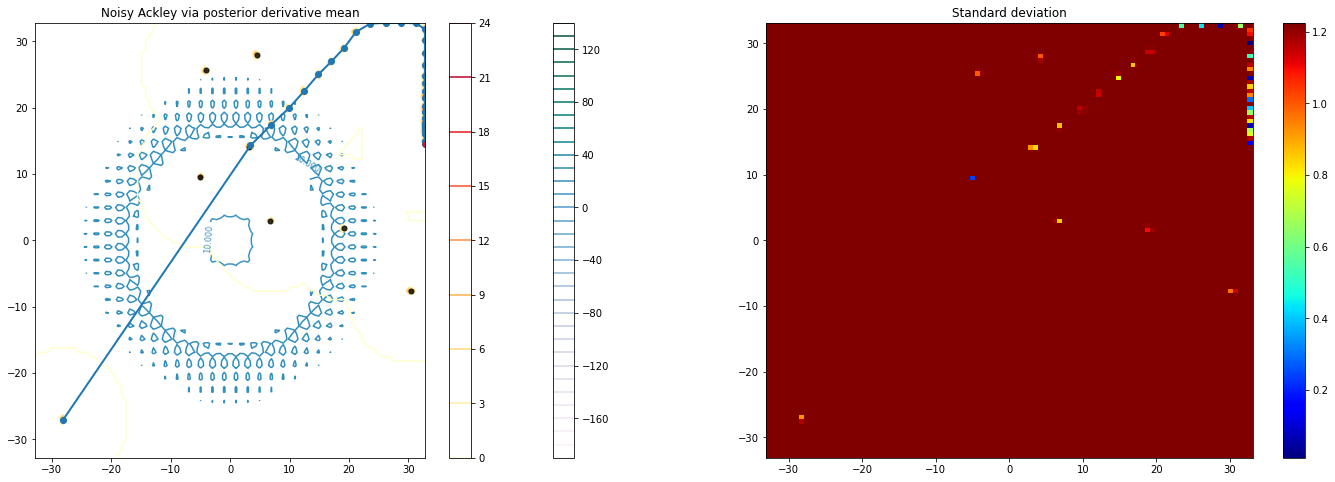

In [24]:
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(24, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)


levels = np.arange(-190, 150, 10)
#     im1 = ax1.contour(X1, X2, (np.sin(x)*np.cos(y)/np.sqrt(x*y)).reshape(X1.shape), cmap="PuBuGn")
# im1 = ax1.contour(X1, X2, (np.sin(x)*np.cos(y)).reshape(X1.shape), cmap="PuBuGn") 
# im1 = ax1.contour(X1, X2, functions.Shubert().func(mesh).reshape(X1.shape), levels, cmap="PuBuGn") 
im1 = ax1.contour(X1, X2, functions.Ackley_2().func(mesh).reshape(X1.shape), levels, cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(gp.X[:init_size, 0], gp.X[:init_size, 1], "ok", markersize=5, alpha=0.8)
ax1.plot(gp.X[init_size-1:, 0], gp.X[init_size-1:, 1], 'o-', linewidth=2)
ax1.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)

# ax1.title.set_text("Contour of Noisy sin(x)cos(y)/sqrt(xy)")
# ax1.title.set_text("Noisy Shubert via posterior derivative mean")
ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")

# plot derivative
#     p1 = y*np.cos(y)* ( (2*x*np.cos(x)) - np.sin(x) ) / (2* (x*y)**(3/2))
#     p2 = - x*np.sin(x)* ( (2*y*np.sin(y)) + np.cos(y) ) / (2* (x*y)**(3/2))
#     p1 = np.cos(x)*np.cos(y)
#     p2 = -np.sin(x)*np.sin(y)

#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, p1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, p2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")
# Saving all the plots in 2D_Plots (need to creat a folder) 
filename = 'Ackley_noisy_sample.png'
pl.savefig('2D_Plots/' + filename)
pl.show()

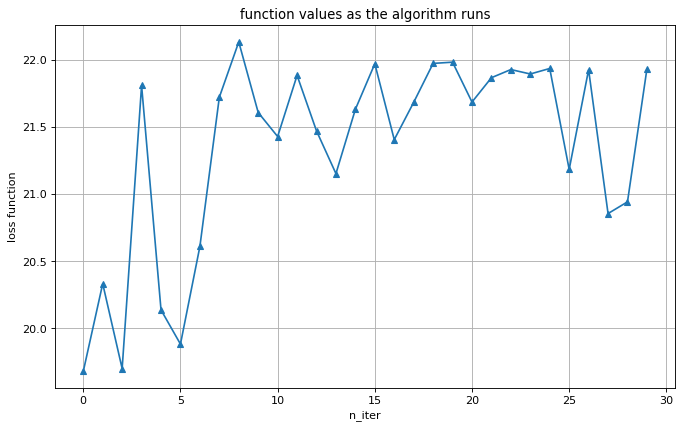

In [25]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [24]:
# only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

In [18]:
# creating meshgrid to plot over entire region
n_mesh = 150
# np.random.seed(seed)  

x1 = np.linspace(bounds[0, 0], bounds[0, 1], n_mesh)
x2 = np.linspace(bounds[1, 0], bounds[1, 1], n_mesh)

X1, X2 = np.meshgrid(x1, x2)
mesh = np.vstack((X1.flatten(), X2.flatten())).T

In [19]:
# construct gp
gp = GP_grad(bounds, Noise, Noise_level)
print(gp.get_hyper())

# optimize hyper and fit alpha
init_size = 5
X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(init_size, dim)))
gp.set_data(X, f(X))
gp.optimize()
gp.fit()
# get_kernel() 
print(gp.get_hyper())

# posterior mean and cov
mu, covar = gp.posterior(mesh)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)

Kt = gp.cov_RBF(mesh, mesh, gp.get_hyper())
K_11 = gp.K11(mesh)
K_01 = gp.K01(mesh)

{'var': 1, 'lengthscale': 1}
{'var': 1.5, 'lengthscale': 1.0}


KeyboardInterrupt: 

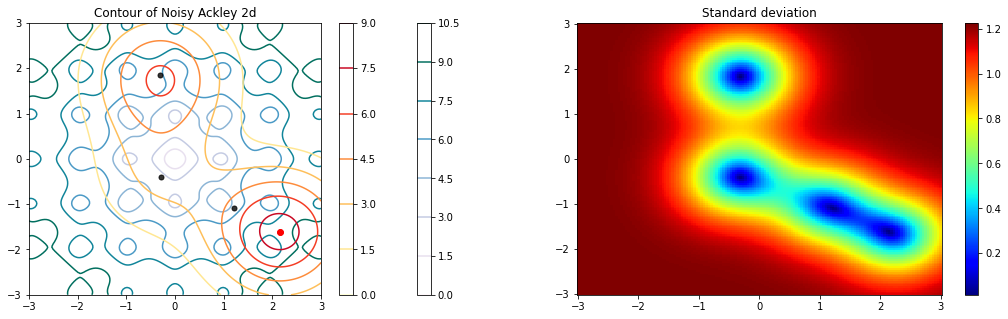

w:  [[2.55704698 2.15436242]]


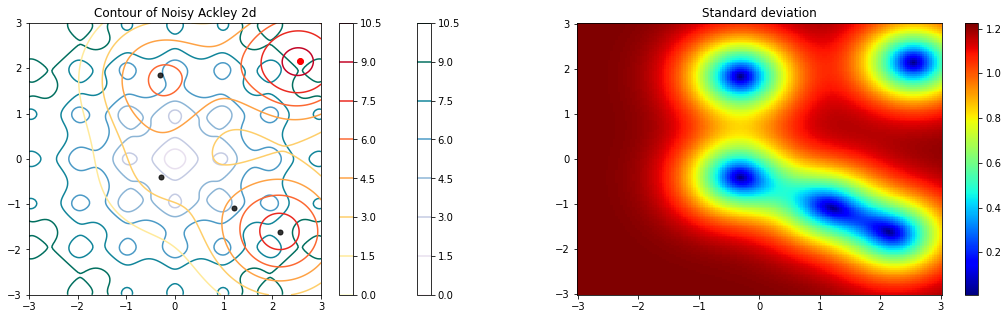

w:  [[-3. -3.]]


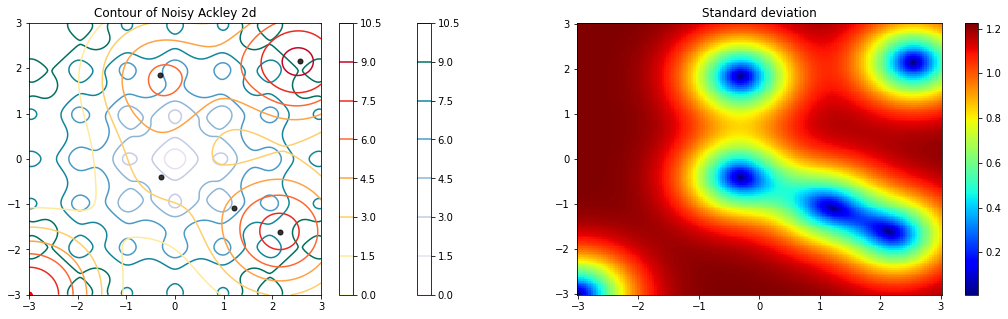

w:  [[-2.0738255  -0.26174497]]


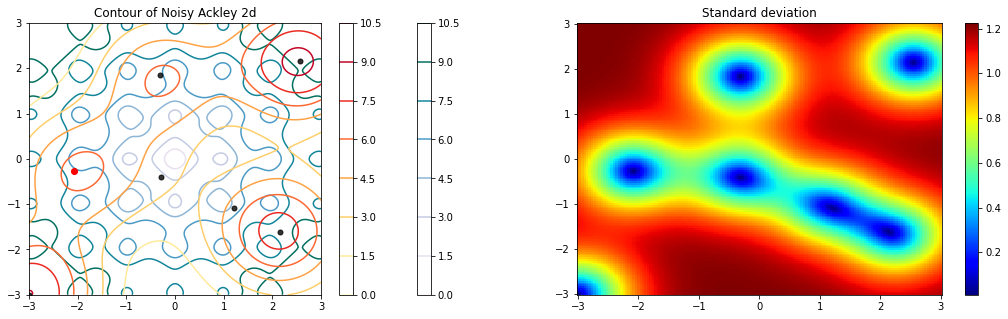

w:  [[-3.          1.63087248]]


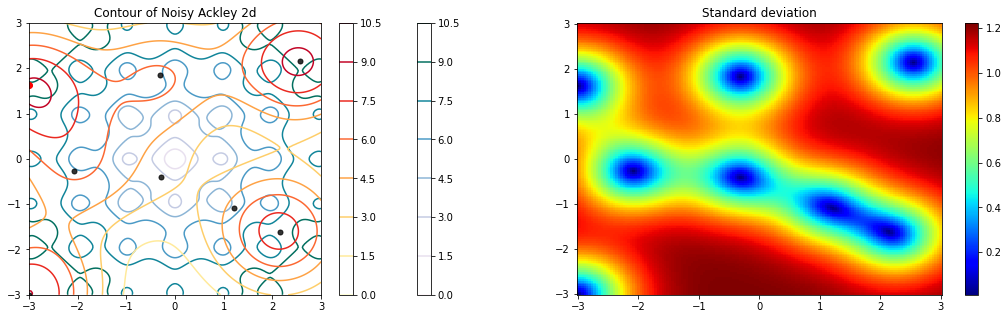

w:  [[-0.06040268 -2.71812081]]


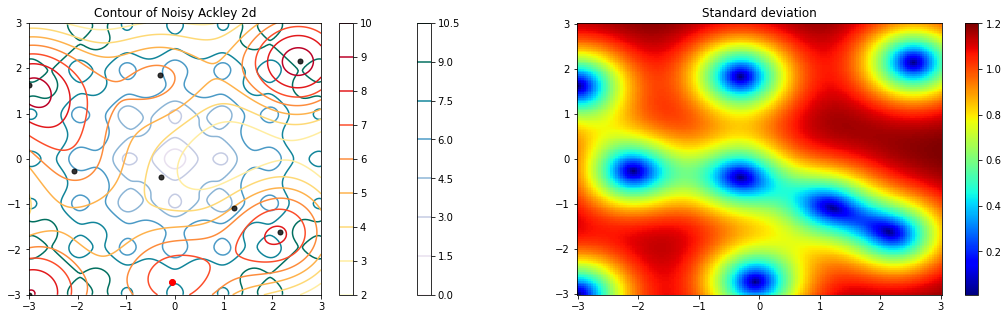

w:  [[-1.30872483  3.        ]]


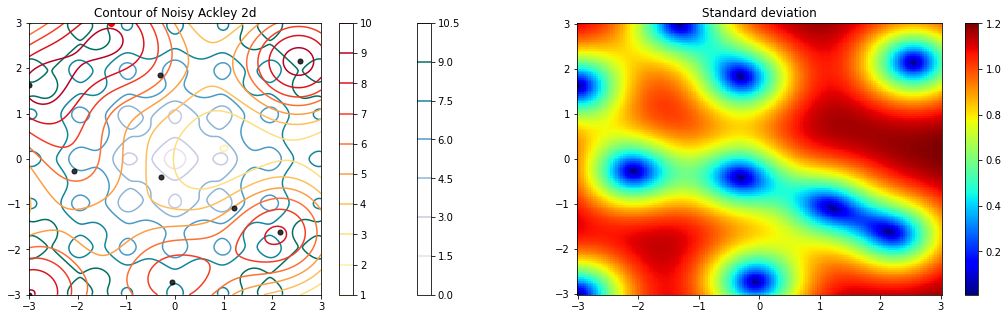

w:  [[-1.4295302  -2.19463087]]


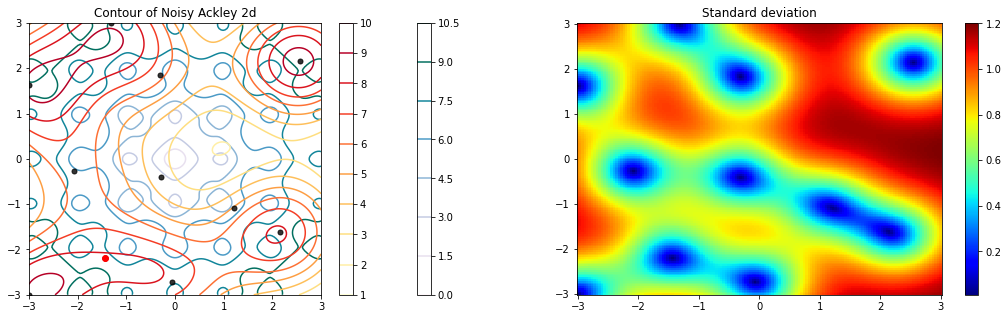

w:  [[0.90604027 0.5033557 ]]


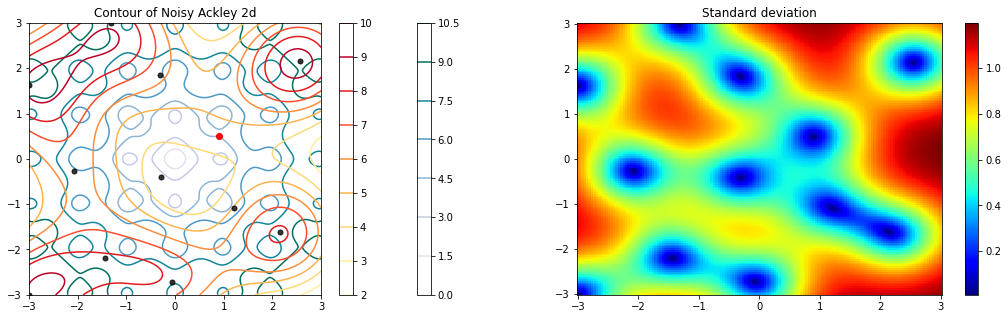

w:  [[ 3. -3.]]


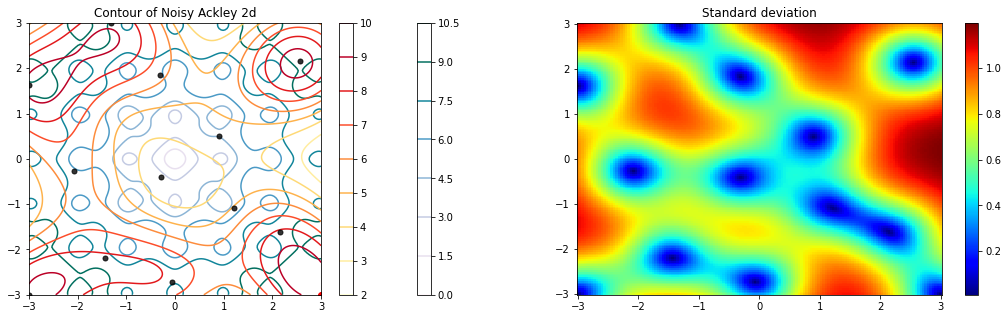

w:  [[ 3.         -0.10067114]]


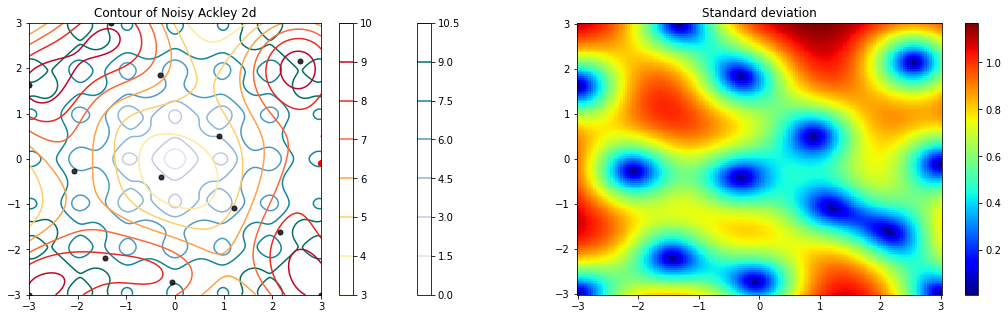

w:  [[0.86577181 3.        ]]


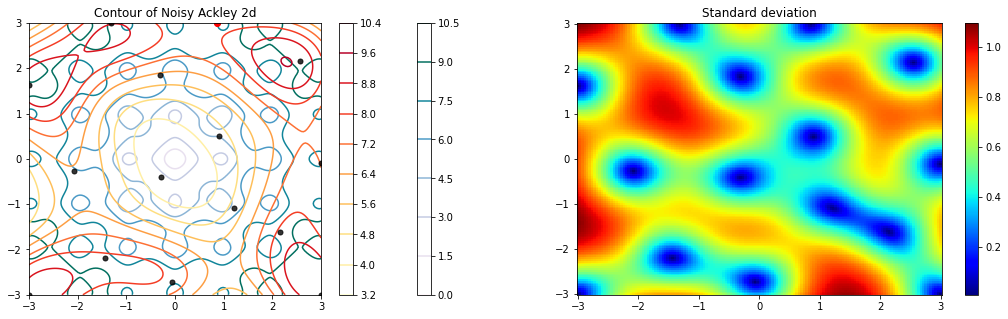

w:  [[ 0.06040268 -0.74496644]]


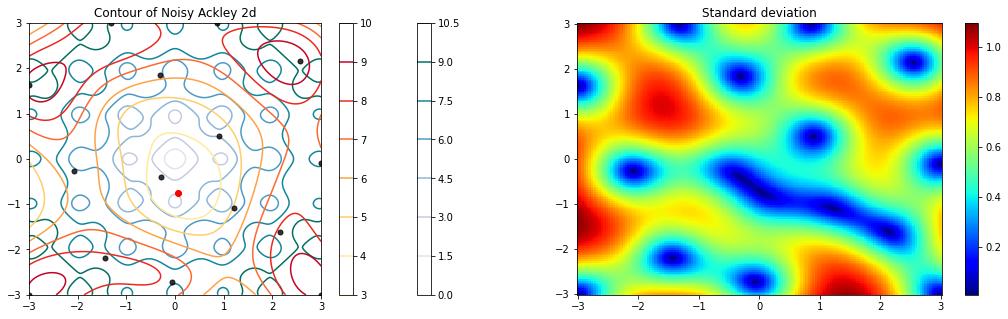

w:  [[ 0.22147651 -0.66442953]]


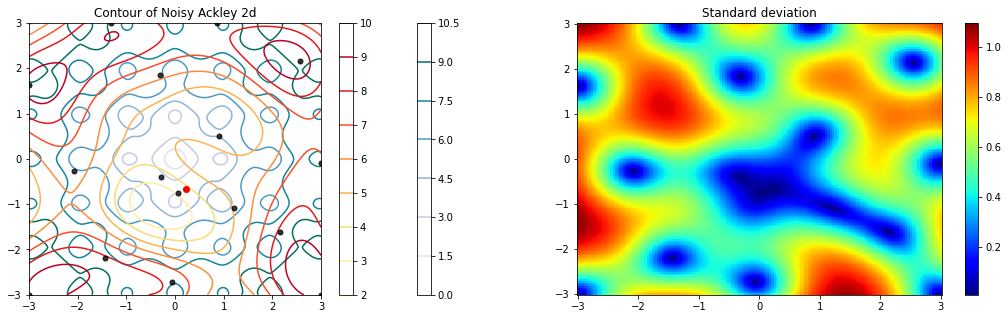

w:  [[-0.34228188 -1.06711409]]


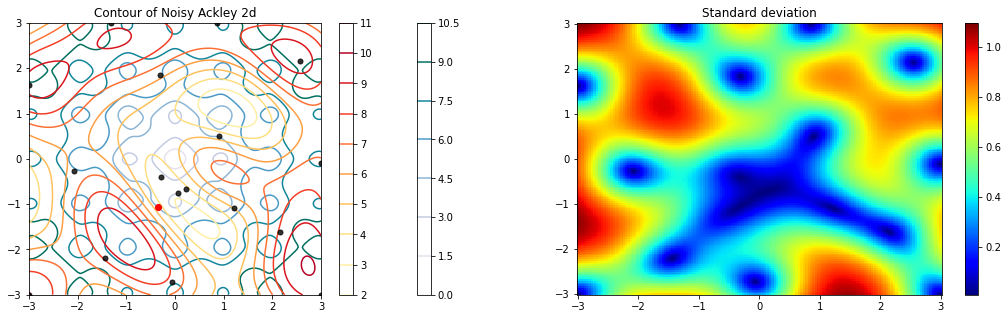

w:  [[1.30872483 1.10738255]]


KeyboardInterrupt: 

In [13]:
n_iter = 60
history = []
w = X[0].reshape(-1, gp.dim)

x = mesh[:,0]
y = mesh[:,1]
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_mesh**dim)) # LL^T = Sigma (posterior covariance)
    
    fig, ((ax1, ax2)) = pl.subplots(1, 2, figsize=(18, 5))

    # plot function
    im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
    fig.colorbar(im, ax=ax2)

    im1 = ax1.contour(X1, X2, functions.Ackley_2().func(mesh).reshape(X1.shape), cmap="PuBuGn")
    im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax1)

    ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
    ax1.plot(w[:, 0], w[:, 1], "ro")
    
    ax1.title.set_text("Contour of Noisy Ackley 2d")
    ax2.title.set_text("Standard deviation")
    
    # Saving all the plots in 2D_Plots (need to creat a folder) 
    filename = 'Ackley_TS_' + str(i) + '.png'
    pl.savefig('2D_Plots/' + filename)
    pl.show()
    
    f_post = mu.reshape(-1, 1) + np.dot(L, np.random.normal(size=(n_mesh**dim, 1)))
    arg_min = np.argmin(f_post)
    w = mesh[arg_min].reshape(w.shape)

    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w.reshape(1, -1), f(w))
    gp.fit()

In [ ]:
# Creates the .gif from the saved plots for the 2D_Plots dir.
filenames = []
for i in range(Budget):
    filename = 'Ackley_TS_' + str(i) + '.png'
    filenames.append(filename)

frames=[]
for filename in filenames:
    frames.append(imageio.imread('2D_Plots/' + filename))
exportname = 'Ackley_TS.gif'

kargs = { 'duration': 0.5 }
imageio.mimsave(exportname, frames, 'GIF', **kargs)